In [1]:
%matplotlib inline

from __future__ import absolute_import
from __future__ import print_function

import tensorflow as tf
import numpy as np

import os
import codecs
import nltk.data
import collections
from glob import glob
from random import shuffle
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords as nltk_stopwords
import matplotlib.pyplot as plt

punctuation_remover = RegexpTokenizer(r'\w+')
stopwords = nltk_stopwords.words('english')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [2]:
sess = tf.InteractiveSession()

In [3]:
vocab_size = 50000

def stopword_filter(text):
    return " ".join([word for word in text.split() if word not in stopwords])

def read_name_data(data_dir):
    with open(os.path.join(data_dir, 'name.txt')) as f:
        name_lists = f.readlines()
        
    names = [name.lower().strip().split('\t') for name in name_lists]

    #name_counter = collections.Counter([word for name_set in names for name in name_set for word in name.split()])
    #print(name_counter.most_common(100))

    name2idx = {}
    nameword2idx = {}

    for idx, name_set in enumerate(names):
        for name in name_set:
            word_in_name = name.split()
            name_without_punctuation = " ".join(punctuation_remover.tokenize(name))
            name2idx[name_without_punctuation] = idx

            for name in [name_without_punctuation] + word_in_name:
                nameword2idx[name] = idx

    idx2name = dict(zip(name2idx.values(), name2idx.keys()))
    
    return names, name2idx, idx2name, nameword2idx

def read_data_as_words(data_dir):
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    
    text = ""
    for filename in glob(os.path.join(data_dir, "*.txt")):
        if 'name.txt' in filename:
            continue
        with open(filename) as f:
            text += f.read()
    return text.split()

def read_data_as_sentences(data_dir, nameword2idx):
    sentences = []

    for filename in glob(os.path.join(data_dir, "*.txt")):
        if 'name.txt' in filename:
            continue

        with codecs.open(filename, 'r', 'utf-8') as f:
            nltk_splited_sentences = tokenizer.tokenize(stopword_filter(f.read().encode('ascii','ignore').lower()))
            current_sentences = [" ".join(punctuation_remover.tokenize(sentence)) for sentence in nltk_splited_sentences
                                 if any(word in nameword2idx.keys() for word in sentence.split())]
            sentences.extend(current_sentences)

            print(" [*] %s finished: %d / %d" % (filename, len(current_sentences), len(nltk_splited_sentences)))

    idx2sentences = {}
    for sentence in sentences:
        inserted_ids = []
        for idx in [idx for nameword, idx in nameword2idx.items() if nameword in sentence]:
            if idx not in inserted_ids:
                idx2sentences.setdefault(idx, []).append(" ".join([word for word in sentence.split() if word not in nameword2idx.keys()]))
                inserted_ids.append(idx)

    new_sentences = []
    name_idx_of_sentence = []
    for idx in idx2sentences.keys():
        for sentence in idx2sentences[idx]:
            new_sentences.append(sentence)
            name_idx_of_sentence.append(idx)

    print(" [*] Total sentences : %d" % (len(sentences)))
    return new_sentences, name_idx_of_sentence

In [4]:
def build_dataset_from_sentences(sentences, name_idx_of_sentence):
    words = [word for sentence in sentences for word in sentence.split()]
    
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocab_size - 1))

    word2idx = dict()
    for word, _ in count:
        word2idx[word] = len(word2idx)

    data = list()
    label_data = list()
    unk_count = 0
    for sentence, name_idx in zip(sentences, name_idx_of_sentence):
        for word in sentence.split():
            if word in word2idx:
                index = word2idx[word]
            else:
                index = 0
                unk_count = unk_count + 1
            data.append(index)
            label_data.append(name_idx)

    count[0][1] = unk_count
    idx2word = dict(zip(word2idx.values(), word2idx.keys()))

    return word2idx, idx2word, data, label_data, count

def generate_batch(data, label_data, batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

    for i in xrange(batch_size):
        batch[i] = data[data_index]
        labels[i] = label_data[data_index]
        
        data_index = (data_index + 1) % len(data)

    return batch, labels

In [5]:
data_dir = './data'

words = read_data_as_words(data_dir)
print('Data size :', len(words))

names, name2idx, idx2name, nameword2idx = read_name_data(data_dir)
print('# of names :', len(names))

sentences, name_idx_of_sentence = read_data_as_sentences(data_dir, nameword2idx)

print("Unkown names : %s" % (set(name2idx.values()) - set(name_idx_of_sentence)))

Data size : 1081571
# of names : 185
 [*] ./data/1.txt finished: 2263 / 6358
 [*] ./data/6.txt finished: 4416 / 11431
 [*] ./data/2.txt finished: 2704 / 6496
 [*] ./data/5.txt finished: 6939 / 17300
 [*] ./data/7.txt finished: 4916 / 14304
 [*] ./data/4.txt finished: 5452 / 13804
 [*] ./data/3.txt finished: 3483 / 8660
 [*] Total sentences : 30173
Unkown names : set([98, 179, 110])


In [6]:
word2idx, idx2word, data, label_data, count = build_dataset_from_sentences(sentences, name_idx_of_sentence)

combined = zip(data, label_data)
shuffle(combined)

data[:], label_data[:] = zip(*combined)

print('Most common words (+UNK) :', count[:5])

Most common words (+UNK) : [['UNK', 0], ('said', 13861), ('back', 4619), ('could', 4338), ('him', 4270)]


In [7]:
data_index = 0
batch_size = 128
skip_window = 4
num_skips = 2

name_size = len(idx2name)
embed_size = 128
neg_sample_size = 64

num_steps = 50001

x_ = tf.placeholder(tf.int32, [batch_size, 1])
x = tf.reshape(x_, [batch_size])
y_ = tf.placeholder(tf.int32, [batch_size])
y = tf.reshape(y_, [batch_size, 1])
neg_y = tf.placeholder(tf.int32, [neg_sample_size])

init_width = 0.5 / embed_size

embed = tf.Variable(tf.random_uniform([name_size, embed_size], -init_width, init_width))
w = tf.Variable(tf.zeros([vocab_size, embed_size]))
b = tf.Variable(tf.zeros([vocab_size]))

pos_embed = tf.nn.embedding_lookup(embed, x, name="pos_embed") # [batch_size x embed_size]
# pos_w = tf.nn.embedding_lookup(w, y, name="pos_w")             # [batch_size x embed_size]
# pos_b = tf.nn.embedding_lookup(b, y, name="pos_b")             # [batch_size x 1]

# pos_y_ = tf.add(tf.reduce_sum(tf.mul(pos_embed, pos_w), 1), pos_b) # [batch_size]

# # neg_embed = pos_embed
# neg_w = tf.nn.embedding_lookup(w, neg_y, name="neg_w") # [neg_sample_size x embed_size]
# neg_b = tf.nn.embedding_lookup(b, neg_y, name="neg_b") # [neg_sample_size]

# neg_y_ = tf.matmul(pos_embed, neg_w, transpose_b=True) + neg_b # [batch_size x neg_sample_size]

# pos_y = tf.ones_like(pos_y_)
# neg_y = tf.ones_like(neg_y_)

# pos_loss = tf.nn.sigmoid_cross_entropy_with_logits(pos_y_, tf.ones_like(pos_y_))
# neg_loss = tf.nn.sigmoid_cross_entropy_with_logits(neg_y_, tf.zeros_like(neg_y_))

loss = tf.reduce_mean(
      tf.nn.nce_loss(w, b, pos_embed, y, neg_sample_size, vocab_size)
)

##################
# Optimizer
##################

global_step = tf.Variable(0, name="global_step")
inc = global_step.assign_add(1)

# total_word_processed = float(word_per_epoch * epochs_to_train)

learning_rate = 0.01
lr = learning_rate * tf.maximum(
    0.001,
    1.0 - tf.cast(global_step, tf.float32) / num_steps
)

# loss = (tf.reduce_sum(pos_loss) + tf.reduce_sum(neg_loss))/batch_size

with tf.control_dependencies([inc]):
    #train = tf.train.GradientDescentOptimizer(lr).minimize(loss, global_step=global_step)
    train = tf.train.GradientDescentOptimizer(0.01).minimize(loss, global_step=global_step)
    
# norm = tf.sqrt(tf.reduce_sum(tf.square(embed), 1, keep_dims=True))
# nembed = embed / norm
nembed = tf.nn.l2_normalize(embed, 1)

In [8]:
tf.initialize_all_variables().run()
average_loss = 0
for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        data, label_data, batch_size, num_skips, skip_window
    )
    feed_dict = {x_: batch_labels, y_: batch_inputs}
    _, loss_val = sess.run([train, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
        if step > 0:
            average_loss = average_loss / 2000

        print("Average loss at step ", step, ": ", average_loss)
        average_loss = 0

Average loss at step  0 :  292.125732422
Average loss at step  2000 :  261.835095901
Average loss at step  4000 :  217.744873871
Average loss at step  6000 :  161.365386314
Average loss at step  8000 :  123.128396046
Average loss at step  10000 :  95.4425538197
Average loss at step  12000 :  74.9583306122
Average loss at step  14000 :  61.7318597126
Average loss at step  16000 :  50.9352294474
Average loss at step  18000 :  42.7657742987
Average loss at step  20000 :  36.9338131514
Average loss at step  22000 :  32.0154577179
Average loss at step  24000 :  28.1577199578
Average loss at step  26000 :  25.0358658991
Average loss at step  28000 :  22.4701554866
Average loss at step  30000 :  20.3201020117
Average loss at step  32000 :  18.6181952109
Average loss at step  34000 :  17.0322648077
Average loss at step  36000 :  15.7747924333
Average loss at step  38000 :  14.5728180661
Average loss at step  40000 :  13.6438245394
Average loss at step  42000 :  12.833570467
Average loss at ste

In [9]:
for idx, count in collections.Counter(label_data).items():
    print(idx, idx2name[idx], ":", count)

0 hogwarts : 8134
1 aberforth dumbledore : 456
2 mad eye : 4646
3 brian : 1694
4 alecto carrow : 111
5 alice longbottom : 106
6 alicia spinnet : 734
7 amelia bones : 130
8 amos diggory : 193
9 amycus carrow : 278
10 andromeda tonks : 55
11 angelina johnson : 1169
12 anthony goldstein : 152
13 antioch peverell : 7
14 antonin dolohov : 288
15 arabella figg : 588
16 aragog : 505
17 argus filch : 2412
18 ariana dumbledore : 24320
19 arthur weasley : 385
20 augusta longbottom : 46
21 augustus rookwood : 200
22 aurora sinistra : 84
23 bane : 224
24 bartemius crouch : 2760
25 bathilda bagshot : 723
26 bathsheba babbling : 30
27 beedle the bard : 60842
28 bellatrix lestrange : 1713
29 bertha jorkins : 383
30 blaise zabini : 412
31 buckbeak : 907
32 cadmus peverell : 7
33 cedric diggory : 2951
34 charity burbage : 89
35 charlie weasley : 809
36 cho chang : 13962
37 colin creevey : 595
38 cormac mclaggen : 599
39 cornelius fudge : 3505
40 crookshanks : 1495
41 cuthbert binns : 530
42 dean thomas

In [10]:
saver = tf.train.Saver()
saver.save(sess, os.path.join("./", "p2v.ckpt"), global_step=global_step)

'./p2v.ckpt-100002'

In [11]:
nearby_word = tf.placeholder(dtype=tf.int32)  # word id
nearby_emb = tf.reshape(tf.gather(nembed, nearby_word), [1, embed_size])
nearby_dist = tf.matmul(nearby_emb, nembed, transpose_b=True)
nearby_val, nearby_idx = tf.nn.top_k(nearby_dist, min(100, vocab_size))

def nearby(words, num=20):
    ids = np.array([name2idx.get(x, 0) for x in words])
    vals, idx = sess.run(
        [nearby_val, nearby_idx], {nearby_word: ids})
    for i in xrange(len(words)):
        print("\n%s\n=====================================" % (words[i]))
        for (neighbor, distance) in zip(idx[i, :num], vals[i, :num]):
            print("%-20s %6.4f" % (idx2name[neighbor], distance))

In [12]:
nearby(['harry potter'])


harry potter
harry potter         1.0000
beedle the bard      1.0000
ronald weasley       1.0000
ted tonks            0.9999
hermione granger     0.9999
ariana dumbledore    0.9999
orion                0.9999
william weasley      0.9999
tom                  0.9999
severus snape        0.9999
rubeus hagrid        0.9999
cho chang            0.9999
narcissa malfoy      0.9999
stan shunpike        0.9999
hogwarts             0.9999
lily potter          0.9999
ginevra weasley      0.9999
minerva mcgonagall   0.9999
teddy lupin          0.9999
fred weasley         0.9999


In [13]:
nearby(['severus snape'])


severus snape
severus snape        1.0000
tom                  1.0000
rubeus hagrid        1.0000
narcissa malfoy      1.0000
cho chang            1.0000
hogwarts             1.0000
ariana dumbledore    1.0000
william weasley      1.0000
fred weasley         1.0000
orion                1.0000
george weasley       1.0000
ginevra weasley      1.0000
lily potter          1.0000
stan shunpike        1.0000
teddy lupin          1.0000
godric gryffindor    1.0000
lee jordan           1.0000
neville longbottom   1.0000
katie bell           1.0000
minerva mcgonagall   1.0000


In [14]:
nearby(['albus dumbledore'])


albus dumbledore
brian                1.0000
poppy pomfrey        1.0000
george weasley       1.0000
michael corner       1.0000
lee jordan           1.0000
ludo bagman          1.0000
cedric diggory       1.0000
cornelius fudge      1.0000
lavender brown       1.0000
sybill patricia trelawney 1.0000
argus filch          1.0000
dudley dursley       1.0000
isabelle             1.0000
madam rosmerta       1.0000
dobby                1.0000
draco malfoy         1.0000
xenophilius lovegood 1.0000
fang                 1.0000
gregory goyle        1.0000
hedwig               1.0000


In [15]:
nearby(['albus dumbledore'])


albus dumbledore
brian                1.0000
poppy pomfrey        1.0000
george weasley       1.0000
michael corner       1.0000
lee jordan           1.0000
ludo bagman          1.0000
cedric diggory       1.0000
cornelius fudge      1.0000
lavender brown       1.0000
sybill patricia trelawney 1.0000
argus filch          1.0000
dudley dursley       1.0000
isabelle             1.0000
madam rosmerta       1.0000
dobby                1.0000
draco malfoy         1.0000
xenophilius lovegood 1.0000
fang                 1.0000
gregory goyle        1.0000
hedwig               1.0000


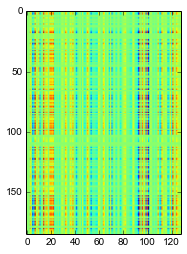

In [16]:
plt.imshow((embed.eval()*100).astype(np.int32))

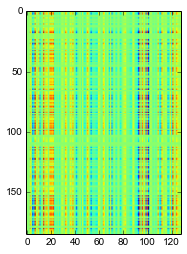

In [17]:
plt.imshow((embed.eval()*100).astype(np.int32))

In [18]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))    #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig(filename)
try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)
except ImportError:
    print("Please install sklearn and matplotlib to visualize embeddings.")

NameError: name 'final_embeddings' is not defined

In [ ]:
flags = tf.app.flags

flags.DEFINE_string("data_dir", './data/', "Directory which contains data files")

FLAGS = flags.FLAGS

class Options(object):
    def __init__(self):
        self.data_dir = FLAGS.data_dir

def main():
    if not FLAGS.data_dir:
        print("--data_dir must be specified")
        sys.exit(1)

    opts = Options()
    read_data(opts.data_dir)
